In [1]:
# How do Classical feedforward neural networks perform when making predictions over random noise

In [2]:
from __future__ import print_function

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
from scipy import stats

import torch_helper_lib as th

In [4]:
# random seeds
torch.manual_seed(1665)
np.random.seed(3266)

torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed_all(999)

In [5]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [6]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [7]:
# create random 28*28 images

# Random images dataset
x_rand = np.random.randint(low=0, high=255, size=(10000,28,28) )
#apply same transforms as for MNIST training
x_rand = x_rand/255.0
x_rand = (x_rand-0.1307)/0.3081

# print(np.mean(x_rand))
# print(np.std(x_rand))

x_rand = torch.Tensor(x_rand)

rand_dataset = torch.utils.data.TensorDataset(x_rand)# create your dataset
rand_dataloader = torch.utils.data.DataLoader(rand_dataset, 
                                              batch_size=32, 
                                              ) # create your dataloader

Shape: torch.Size([10000, 28, 28])
torch.Size([28, 28])


<IPython.core.display.Javascript object>


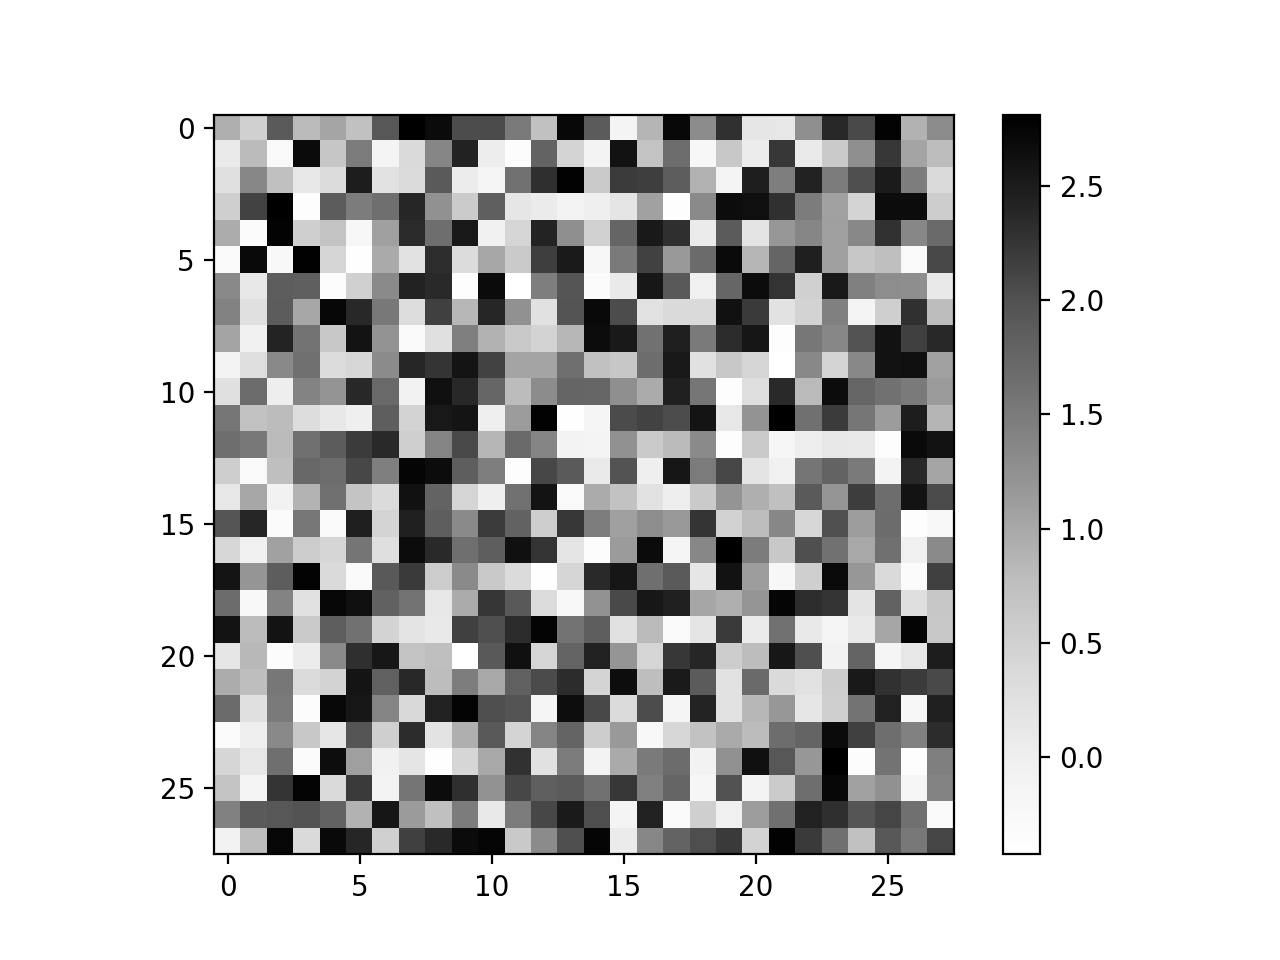

In [8]:
# show an example
print("Shape:", rand_dataloader.dataset.tensors[0].shape)
x = rand_dataloader.dataset.tensors[0][0]
print(x.shape)
# print("sample:", x)

plt.imshow(x, cmap=plt.cm.get_cmap('Greys'))
plt.colorbar()
plt.show()

In [9]:
#  test one model
model_dir = "./saved_models/Classic_MNIST_Net"
model_id = "./saved_models/Classic_MNIST_Net/model_[1024]"
exp_num = "_exp_0"
full_model = "_full.pth"
state_dict = "_state_dict.pth"

full_path = model_id+exp_num+full_model
print(full_path)

./saved_models/Classic_MNIST_Net/model_[1024]_exp_0_full.pth


In [10]:
from torch_helper_lib import Classic_MNIST_Net

In [11]:
# full load
model1 = torch.load(full_path)
model1.to(device)

/usr/local/lib/python2.7/dist-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python2.7/dist-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Classic_MNIST_Net(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=1024, bias=True)
  )
  (fl): Linear(in_features=1024, out_features=10, bias=True)
)

In [12]:
print(model1.state_dict)

<bound method Classic_MNIST_Net.state_dict of Classic_MNIST_Net(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=1024, bias=True)
  )
  (fl): Linear(in_features=1024, out_features=10, bias=True)
)>


In [13]:
# apply model to data
# get predictions 
predictions = np.array([])
for data in rand_dataloader:
    data = data[0].to(device)
    pred = model1(data).cpu().detach().numpy()
    try:
        predictions = np.concatenate((predictions,pred))
    except:
        predictions=pred
        
# for some reason the networks make log_softmax predictions
predictions = np.exp(predictions)

In [14]:
# print first 5 pred
print(np.round(predictions[:5],decimals=2))
print("shape:", predictions.shape)

[[0.49 0.   0.   0.   0.01 0.   0.01 0.   0.48 0.  ]
 [0.05 0.   0.   0.01 0.   0.   0.   0.   0.93 0.  ]
 [0.07 0.   0.   0.01 0.06 0.   0.27 0.   0.57 0.01]
 [0.12 0.   0.   0.02 0.   0.   0.01 0.   0.85 0.  ]
 [0.03 0.   0.01 0.36 0.   0.   0.01 0.   0.58 0.01]]
shape: (10000, 10)


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<IPython.core.display.Javascript object>


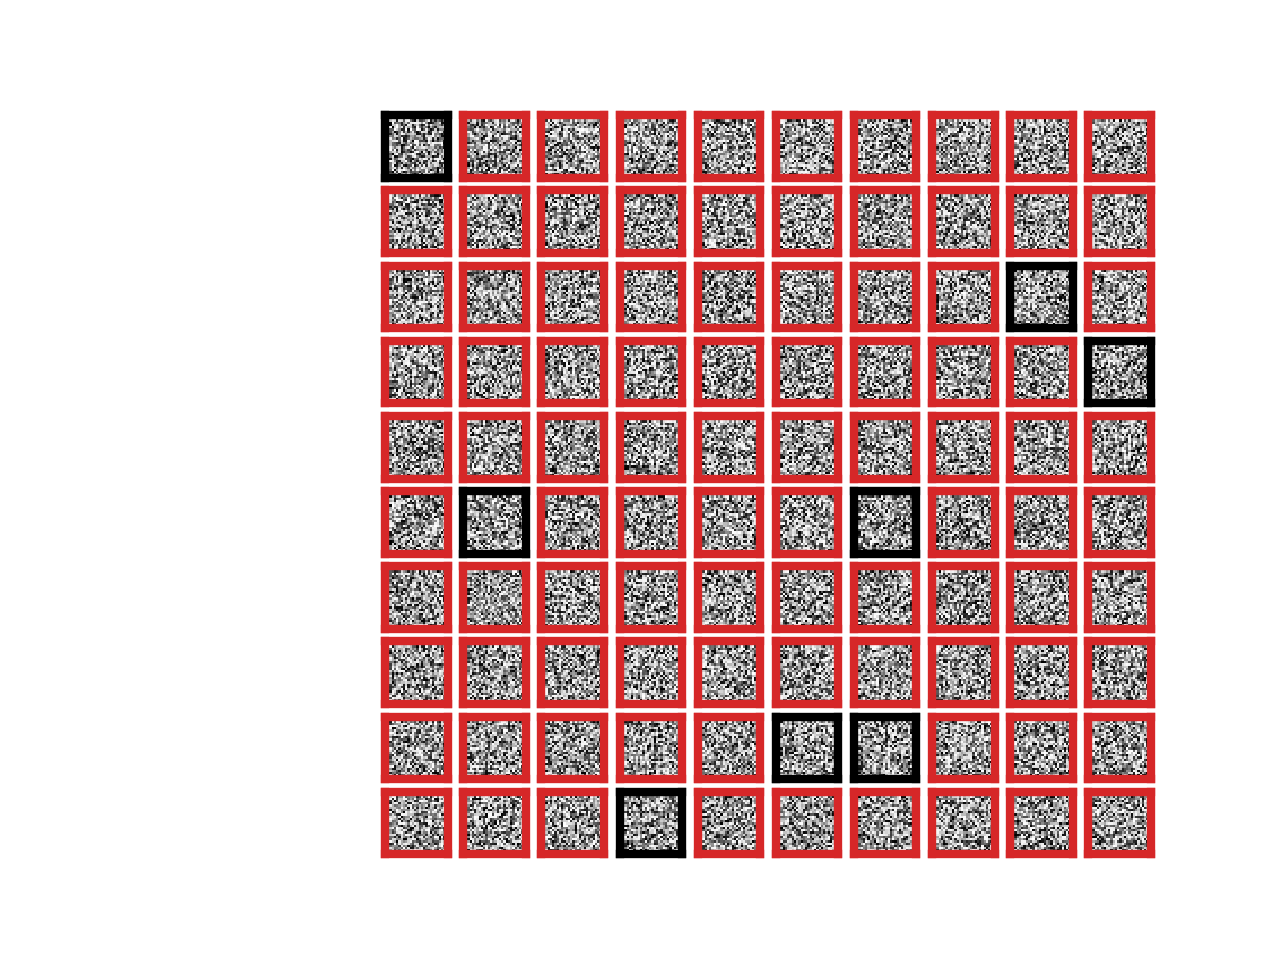

In [15]:
# plot
fig, axes = plt.subplots(nrows=10, ncols=10)
for r in range(10):
    for c in range(10):
        
        x = rand_dataloader.dataset[10*r+c][0].numpy().reshape((28,28))
        
        # is the max bigger than rest combined?
        if np.max(predictions[10*r+c])>=0.5:
            axes[r,c].spines['bottom'].set_color('tab:red')
            axes[r,c].spines['top'].set_color('tab:red')
            axes[r,c].spines['left'].set_color('tab:red')
            axes[r,c].spines['right'].set_color('tab:red')
        
        # is the max close to the min?
        if np.max(predictions[10*r+c])<=0.2:            
            axes[r,c].spines['bottom'].set_color('tab:blue')
            axes[r,c].spines['top'].set_color('tab:blue')
            axes[r,c].spines['left'].set_color('tab:blue')
            axes[r,c].spines['right'].set_color('tab:blue')
            
        axes[r,c].spines['bottom'].set_linewidth(3)
        axes[r,c].spines['top'].set_linewidth(3)
        axes[r,c].spines['left'].set_linewidth(3)
        axes[r,c].spines['right'].set_linewidth(3)
        axes[r,c].tick_params(axis='both', labelbottom='off', labelleft='off', bottom='off', left='off')

        axes[r,c].imshow(x, cmap=plt.cm.get_cmap('Greys'))
#         axes[r,c].axis('off')
plt.subplots_adjust(left=0.3, hspace=0.2)
plt.show()

In [16]:
### Part 2 - Test all the pre-trained models

import os

all_model_paths = sorted([file for file in os.listdir(model_dir) if file.endswith("_full.pth")])
networks_sizes = [[], [8], [128], [1024], [8,8], [128,128], [1024,1024], [8,8,8], [128,128,128], [1024,1024,1024]]


In [17]:
# results will be of the form:
# {model_name: res} with res being a list with the predictions for each class
results_dict = {}

for model_path in all_model_paths:
    
    # full model load
    print("loading model", model_path)
    loaded_model = torch.load(model_dir+'/'+model_path)
    loaded_model.to(device)
    
    # apply model to data
    # get predictions 
    print("making predictions")
    predictions = np.array([])
    for data in rand_dataloader:
        data = data[0].to(device)
        pred = loaded_model(data).cpu().detach().numpy()
        try:
            predictions = np.concatenate((predictions,pred))
        except:
            predictions=pred        

    # for some reason the networks make log_softmax predictions
    predictions = np.exp(predictions)
    
    # we really only care about the max
    maxes = [np.max(p) for p in predictions]
    
    # add to dict
    results_dict[model_path] = maxes

loading model model_[1024, 1024, 1024]_exp_0_full.pth
making predictions
loading model model_[1024, 1024, 1024]_exp_10_full.pth
making predictions
loading model model_[1024, 1024, 1024]_exp_11_full.pth
making predictions
loading model model_[1024, 1024, 1024]_exp_1_full.pth
making predictions
loading model model_[1024, 1024, 1024]_exp_2_full.pth
making predictions
loading model model_[1024, 1024, 1024]_exp_3_full.pth
making predictions
loading model model_[1024, 1024, 1024]_exp_4_full.pth
making predictions
loading model model_[1024, 1024, 1024]_exp_5_full.pth
making predictions
loading model model_[1024, 1024, 1024]_exp_6_full.pth
making predictions
loading model model_[1024, 1024, 1024]_exp_7_full.pth
making predictions
loading model model_[1024, 1024, 1024]_exp_8_full.pth
making predictions
loading model model_[1024, 1024, 1024]_exp_9_full.pth
making predictions
loading model model_[1024, 1024]_exp_0_full.pth
making predictions
loading model model_[1024, 1024]_exp_10_full.pth
making

In [18]:
from scipy.stats import describe
maxes_test = results_dict["model_[8, 8]_exp_0_full.pth"]
print("Min of maxes:", np.min(maxes_test))
print(describe(maxes_test))

Min of maxes: 0.18463291
DescribeResult(nobs=10000, minmax=(0.18463291, 0.9807976), mean=0.61764354, variance=0.036976986, skewness=-0.008354716002941132, kurtosis=-1.0550523216866134)


<IPython.core.display.Javascript object>


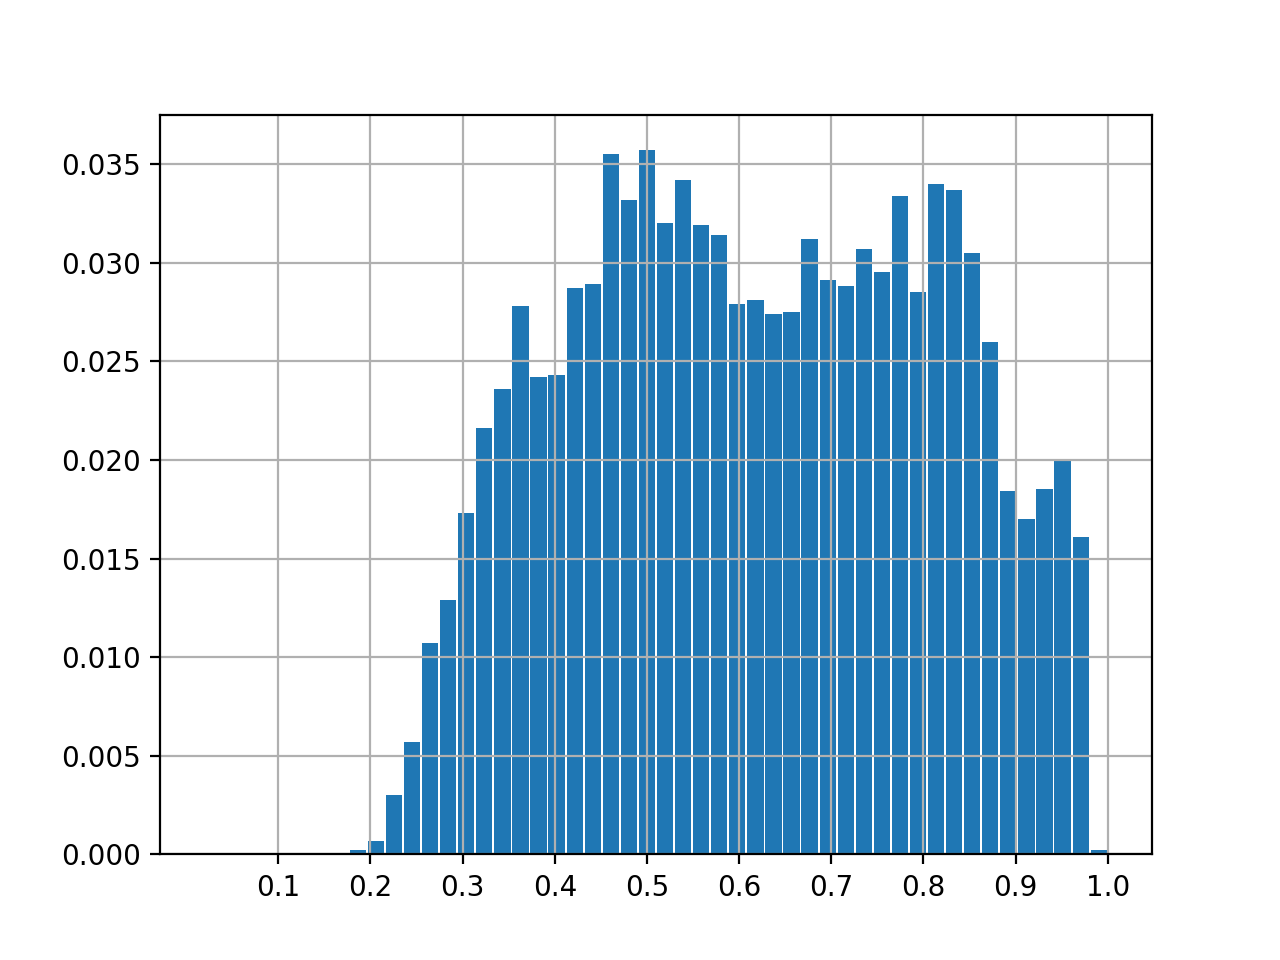

In [19]:
weights = np.ones_like(maxes_test)/len(maxes_test)
plt.hist(maxes_test, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
plt.xticks((np.arange(10)+1)/10.0)
plt.grid(True)
plt.show()

Network size []


<IPython.core.display.Javascript object>


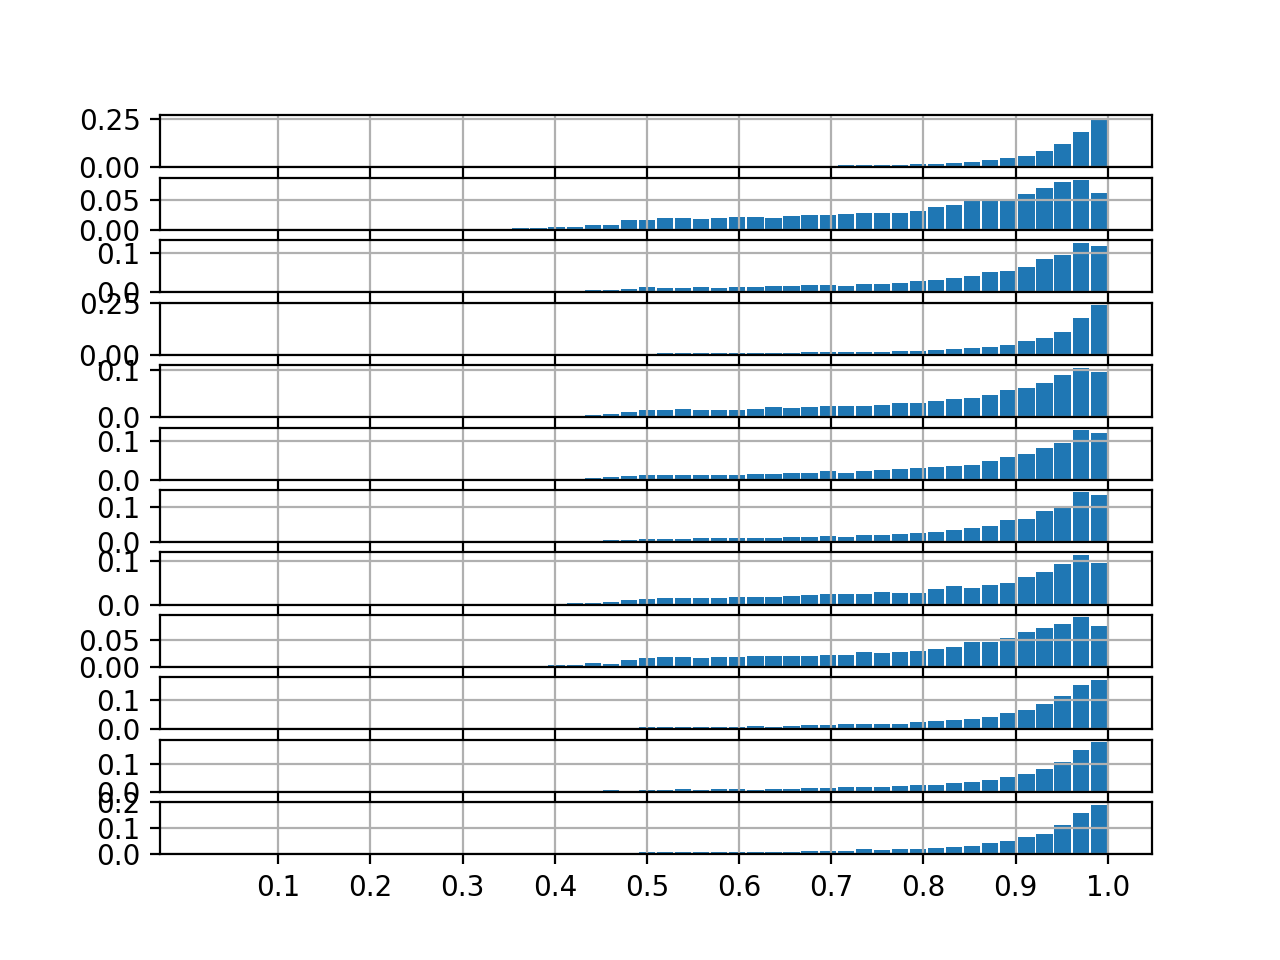

Network size [8]


<IPython.core.display.Javascript object>


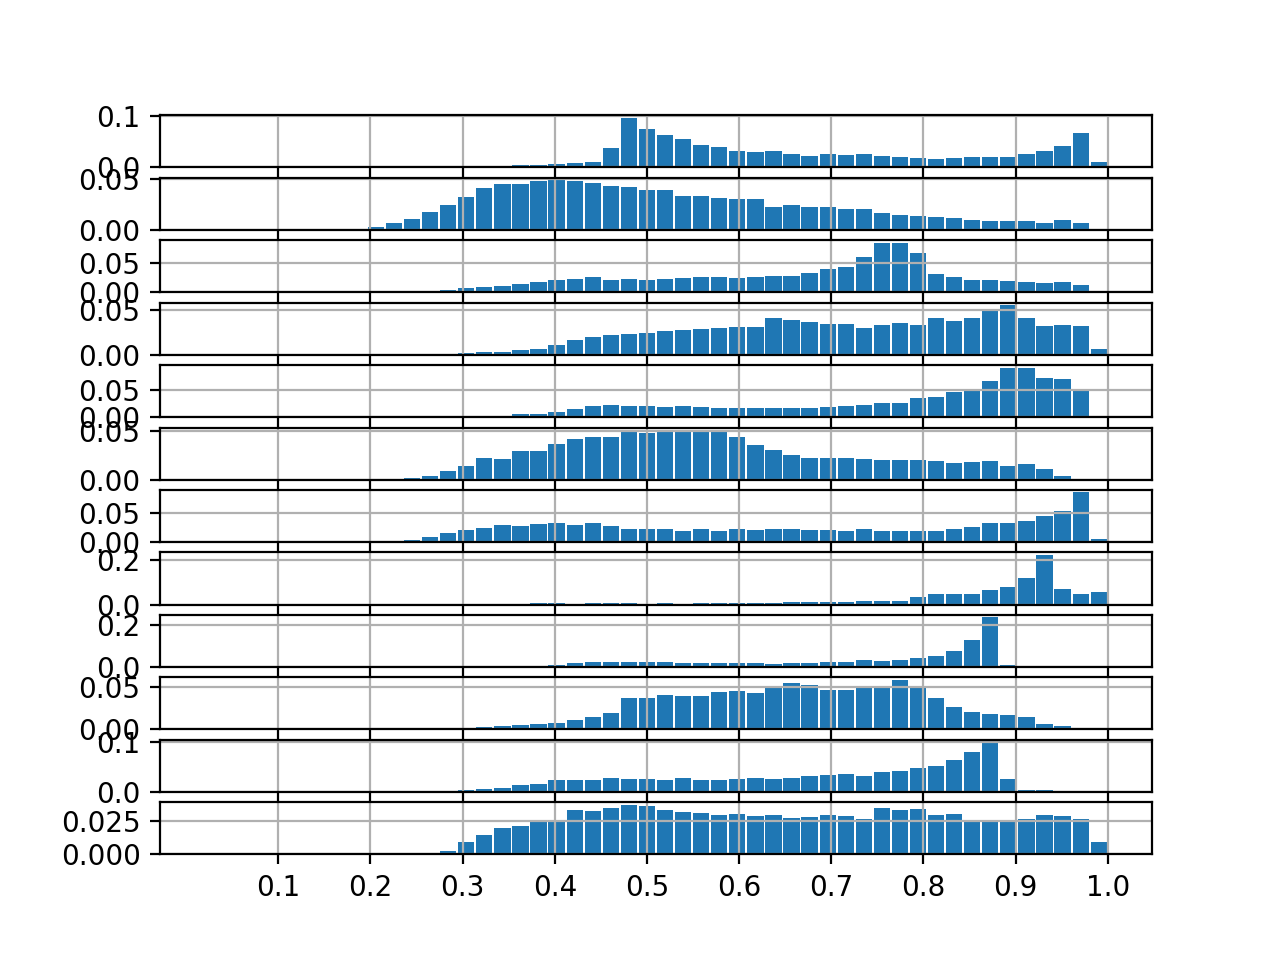

Network size [128]


<IPython.core.display.Javascript object>


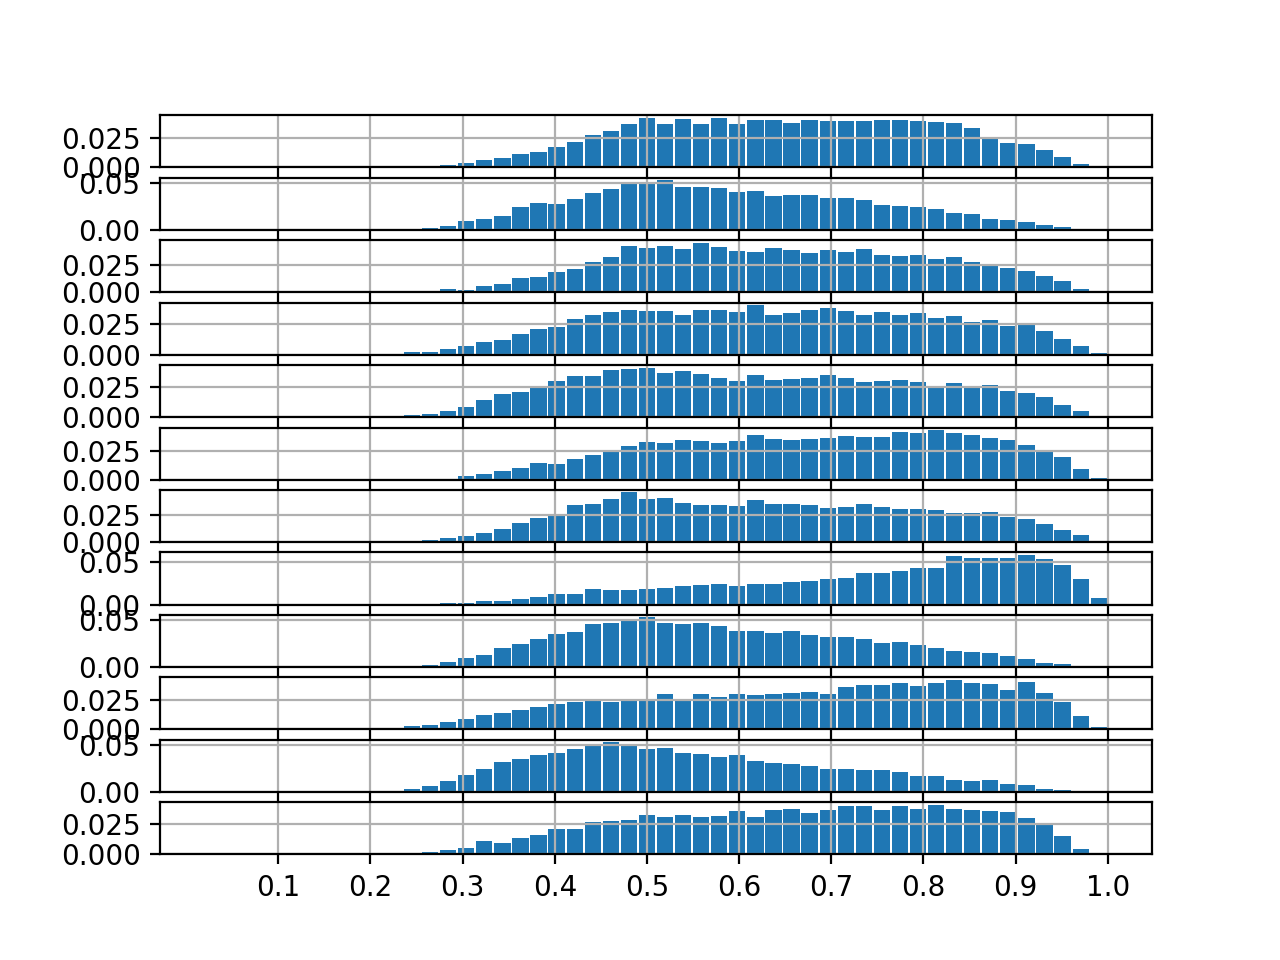

Network size [1024]


<IPython.core.display.Javascript object>


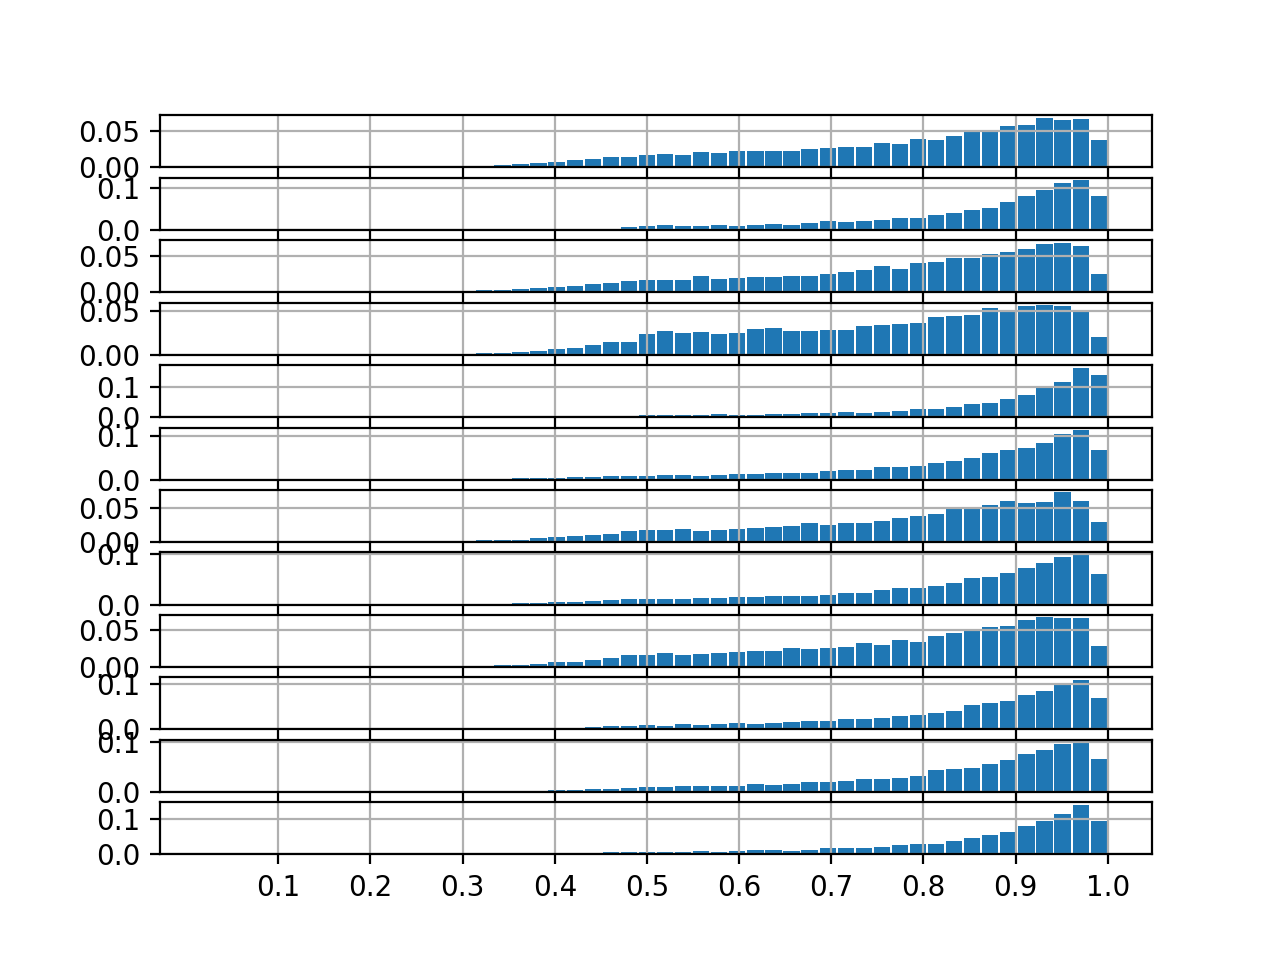

Network size [8, 8]


<IPython.core.display.Javascript object>


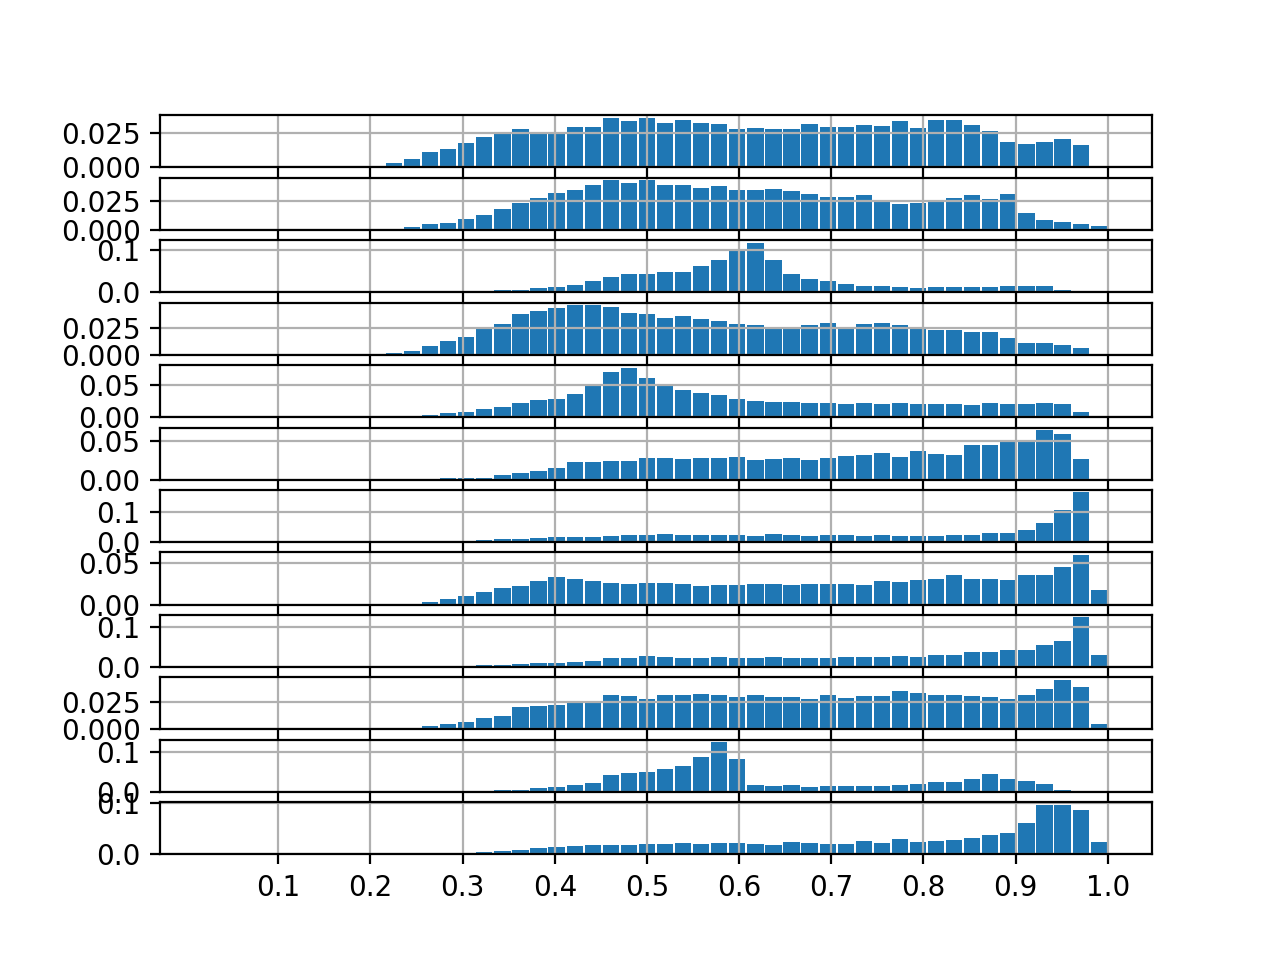

Network size [128, 128]


<IPython.core.display.Javascript object>


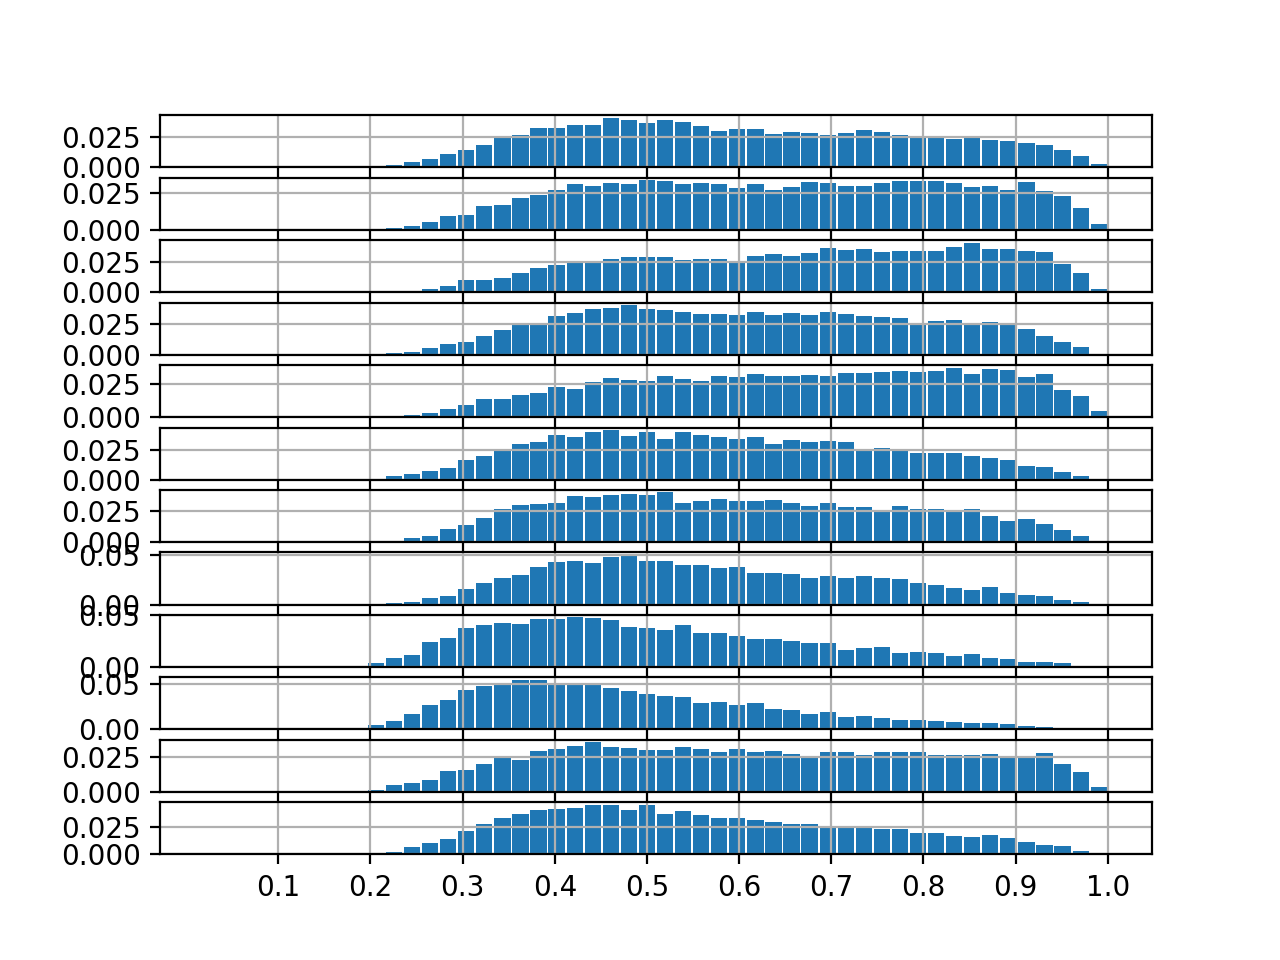

Network size [1024, 1024]


<IPython.core.display.Javascript object>


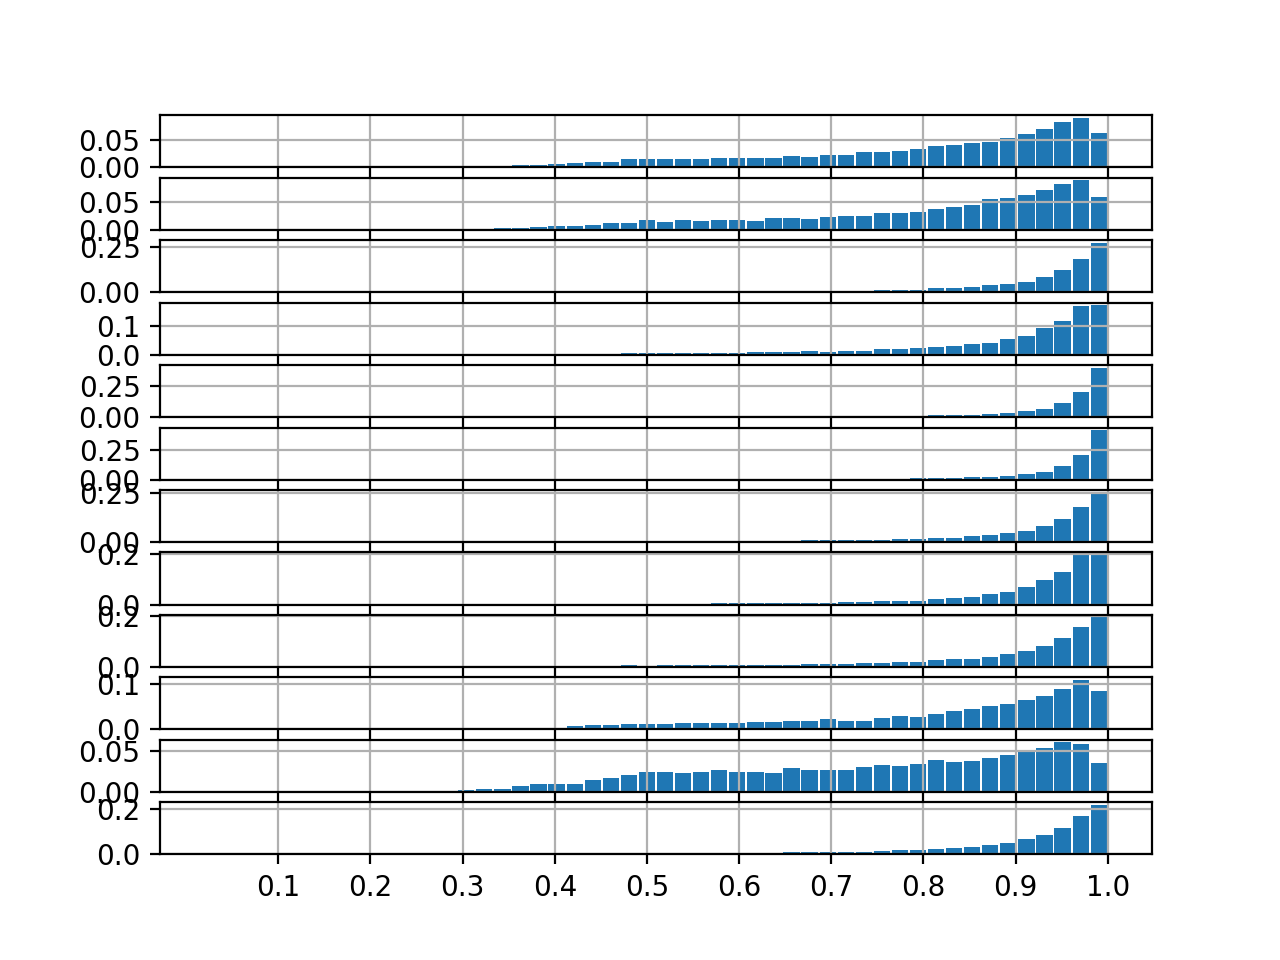

Network size [8, 8, 8]


<IPython.core.display.Javascript object>


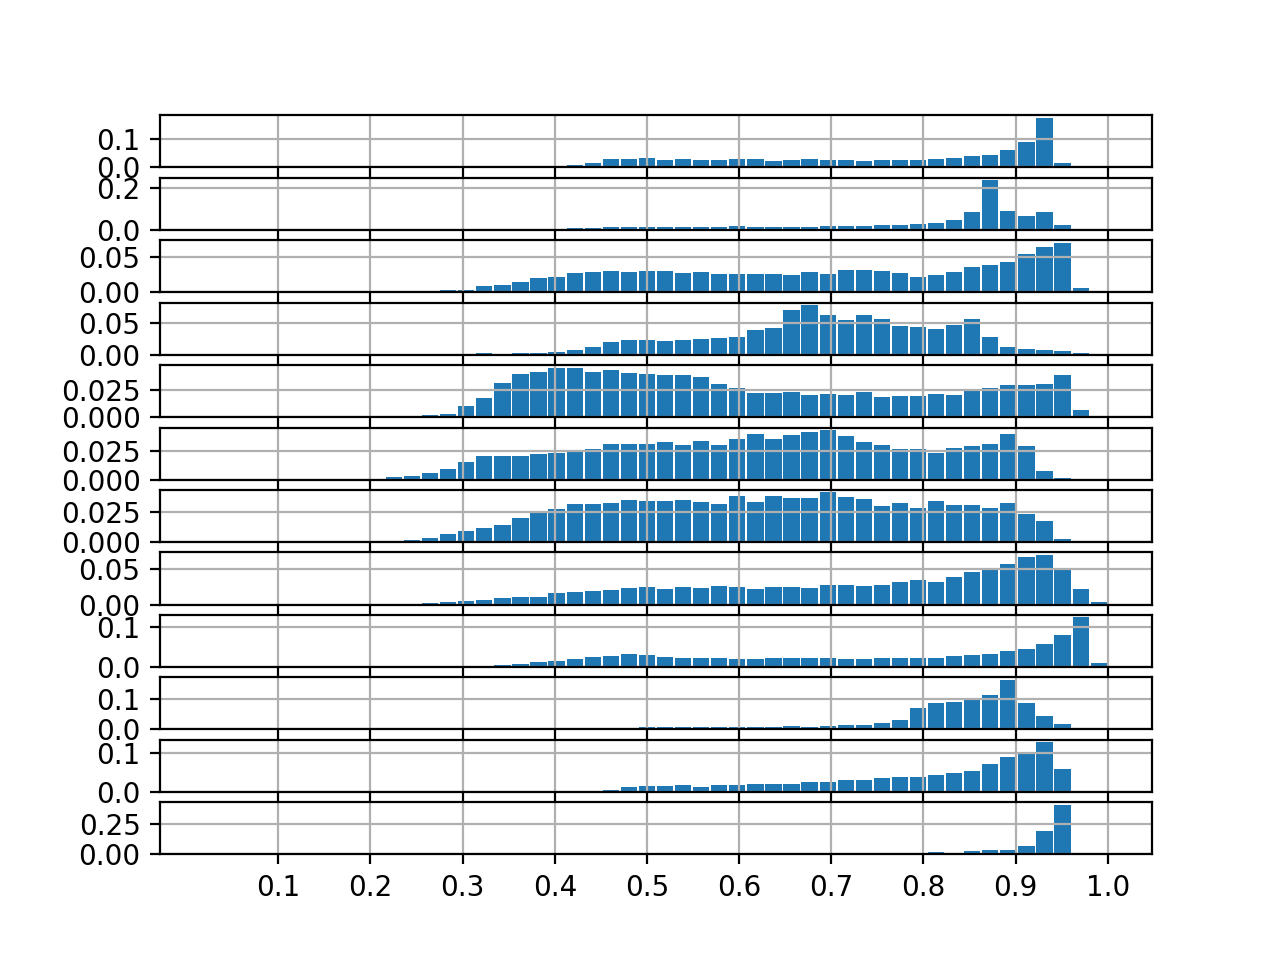

Network size [128, 128, 128]


<IPython.core.display.Javascript object>


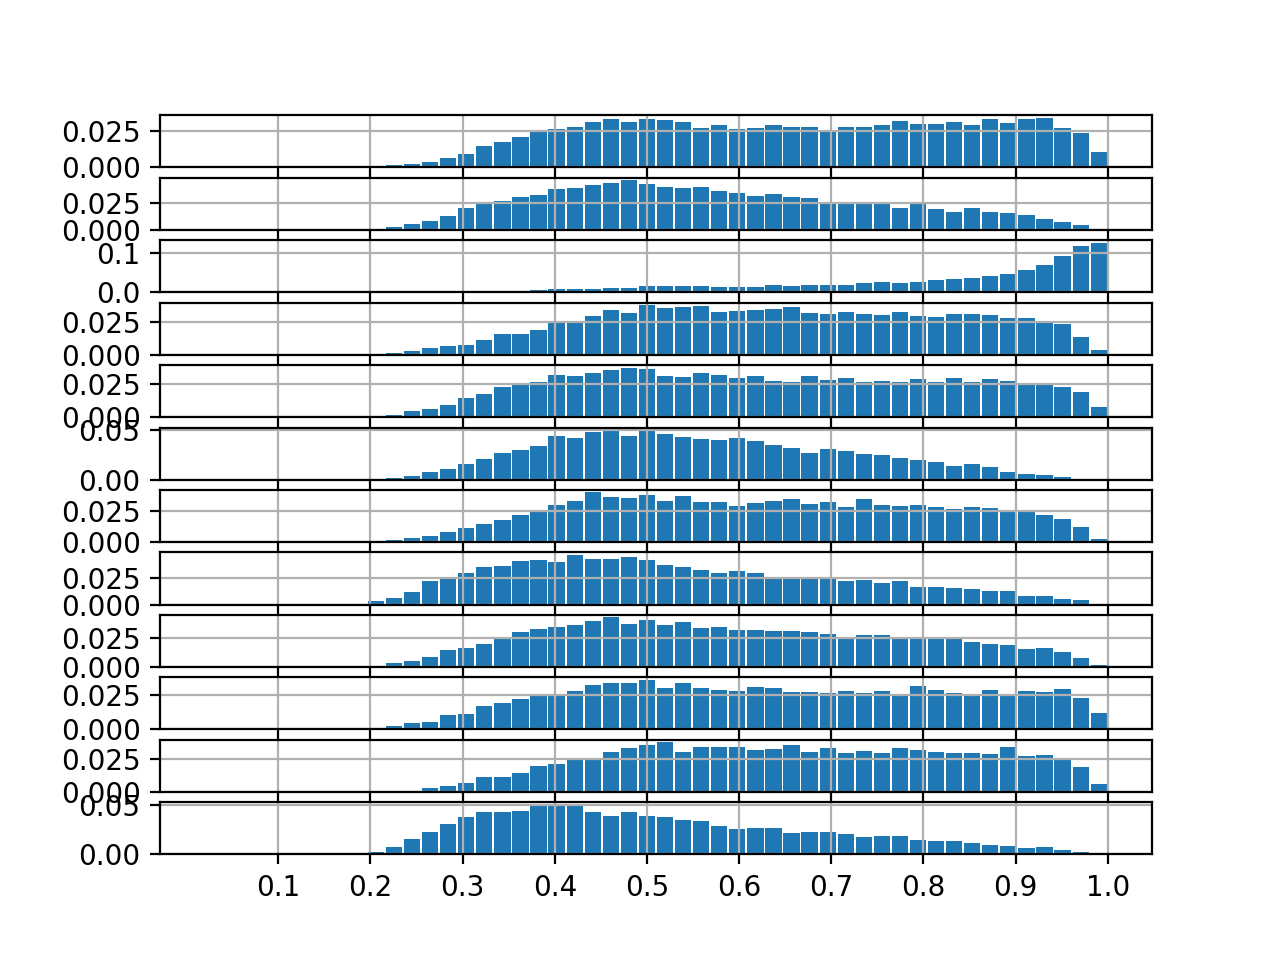

Network size [1024, 1024, 1024]


<IPython.core.display.Javascript object>


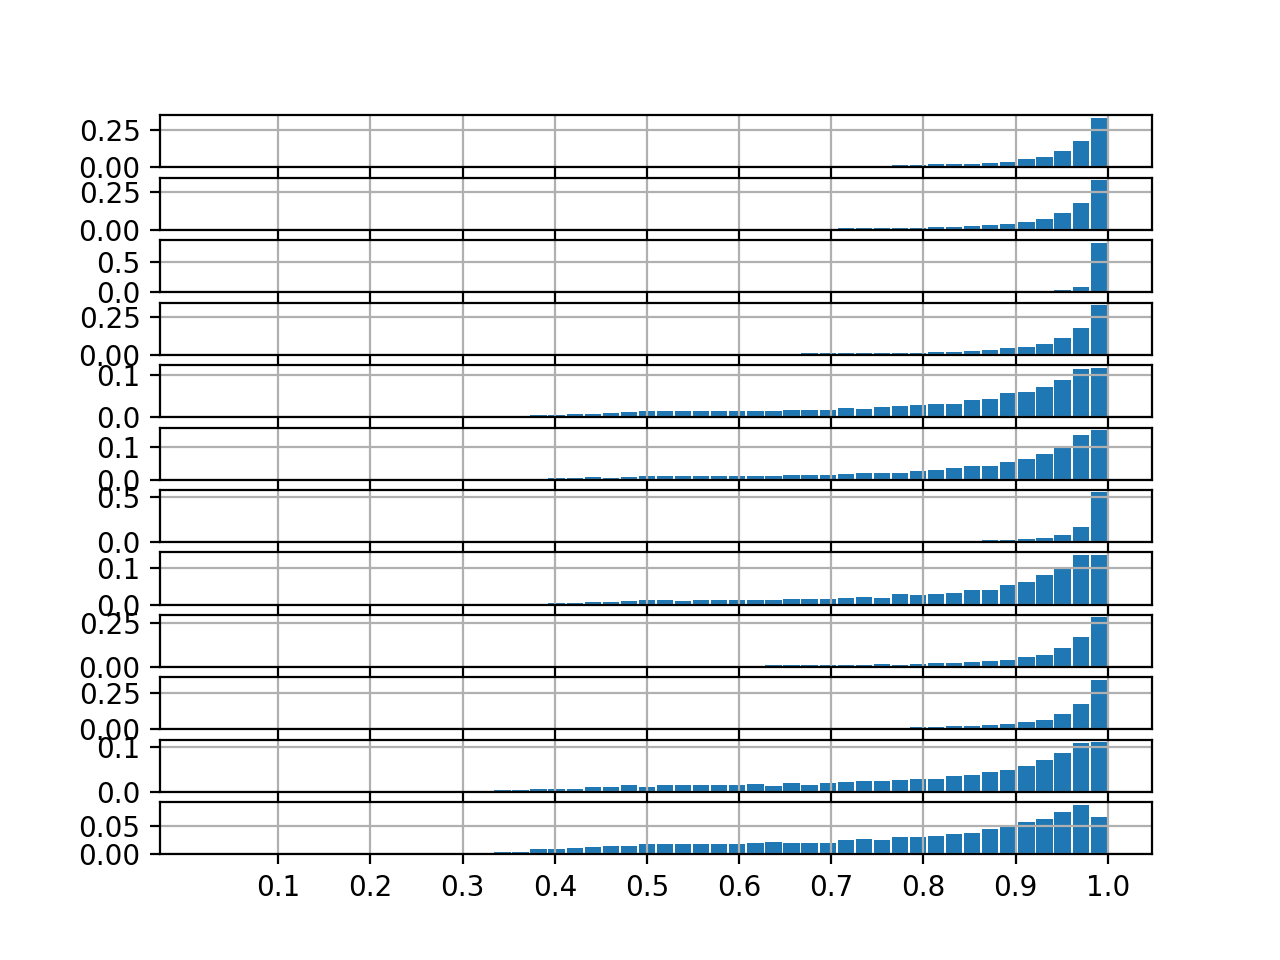

In [20]:
# plot the histogram for each model

for size in networks_sizes:
    print("Network size", size)
    subplot_num = 0
    for k in results_dict.keys():
        if str(size) in k:
            subplot_num += 1
            axe = plt.subplot(12,1, subplot_num)
            axe.hist(results_dict[k], bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
            plt.xticks((np.arange(10)+1)/10.0)
        #     plt.yticks((np.arange(0,11,2))/10.0)
            plt.grid(True)
    plt.show()

